In [953]:
from __future__ import division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from torchvision import transforms, utils
from PIL import Image
from torch.autograd import Variable
import random
import math
from functools import reduce
from scipy import stats

import cv2
from glob import glob

import skimage
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from skimage.color import rgb2grey, rgb2hsv, hsv2rgb, grey2rgb, rgba2rgb
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import random
import math
from functools import reduce

import cv2
from glob import glob

import skimage
from skimage.io import imread
from skimage import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.util import invert
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from skimage.filters import gaussian

from skimage.morphology import erosion, dilation, binary_dilation, opening, closing, white_tophat
from skimage.morphology import disk

import sklearn
from skimage.morphology import label

import utils
from utils import show_images, plot_img_and_hist, add_contour
from loss import show_compare_gt

#import ipy_autoreload
#%autoreload 2 
#%aimport your_mod

In [928]:
#transform = reload(transform)
utils = reload(utils)
loss=reload(loss)
architectures = reload(architectures)
main = reload(main)

In [930]:
import logging
from utils import exceptions_str
from skimage.morphology import reconstruction
from skimage import img_as_float, exposure
from skimage.util import invert
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation, binary_dilation, binary_opening, opening, closing, white_tophat
from skimage.morphology import disk
from scipy import ndimage as ndi


def parametric_pipeline(img,
                invert_thresh_pd = .5,
                circle_size = 7,
                disk_size=10,
                min_distance=9,
                use_watershed=False
                ):
    try:
        circle_size = np.clip(int(circle_size), 1, 30)
        if use_watershed:
            disk_size = np.clip(int(disk_size), 0, 50)
            min_distance = np.clip(int(min_distance), 1, 50)

        # Invert the image in case the objects of interest are in the dark side                                                                                  

        thresh = threshold_otsu(img)
        img_th = img > thresh

        if len(np.where(img_th)[0]) > invert_thresh_pd * img.size:
            img=invert(img)

        # morphological opening (size tuned on training data)                                                                                                    
        #circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size))                                                                         
        circle7=disk(circle_size / 2.0)
        img_open = opening(img, circle7)
        #img_open = cv2.morphologyEx(img, cv2.MORPH_OPEN, circle7)                                                                                               
        #return img_open                                                                                                                                         

        thresh = threshold_otsu(img_open)
        img_th = (img_open > thresh).astype(int)
     # second morphological opening (on binary image this time)                                                                                               
        bin_open = binary_opening(img_th, circle7)
        if not use_watershed:
            return ndi.label(bin_open)[0], thresh

        # WATERSHED                                                                                                                                              
        selem=disk(disk_size)
        dil = binary_dilation(bin_open, selem)
        img_dist = ndi.distance_transform_edt(dil)
        local_maxi = peak_local_max(img_dist,
                                    min_distance=min_distance,
                                    indices=False,
                                    exclude_border=False)
        markers = ndi.label(local_maxi)[0]
        cc = watershed(-img_dist, markers, mask=bin_open, compactness=0, watershed_line=True)

        return cc
    except:
        logging.error("Error in parametric pipeline:\n%s" % exceptions_str())
        return np.zeros_like(img)


In [997]:
def train_transform(img, mask, mask_seg):
    # HACK (make dims consistent, first one is channels)                                                                                                         
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, 2)
    if len(mask_seg.shape) == 2:
        mask_seg = np.expand_dims(mask_seg, 2)
    #img, mask, mask_seg = random_rotate90_transform2(img, mask, mask_seg)
    img = ToTensor()(img)
    mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).float()
    mask_seg = torch.from_numpy(np.transpose(mask_seg, (2, 0, 1))).float()
    return img, mask, mask_seg

# Load Data

In [931]:
utils=reload(utils)
import utils
import main
    
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
dsb_data_dir = os.path.join('..', '..', 'input')
stage_name = 'stage1'


dset = NucleusDataset(dsb_data_dir, stage_name, transform=train_transform)

# hack: this image format (1388, 1040) occurs only ones, stratify complains .. 
dset.data_df = dset.data_df[dset.data_df['size'] != (1388, 1040)]

stratify = dset.data_df['images'].map(lambda x: '{}'.format(x.size))
train_dset, valid_dset = dset.train_test_split(test_size=0.05, random_state=1, shuffle=True, stratify=stratify)
train_loader = DataLoader(train_dset, batch_size=1,shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=1,shuffle=True)



# Load Model

In [932]:
import architectures
model = architectures.CNN()
path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/bce_img_weight_6l/model_save_bce_img_weight_6l_best.pth.tar'
#path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/mse_sgd/model_save_mse_sgd_best.pth.tar'
#path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/dice/model_save_dice_best.pth.tar'
main.load_checkpoint(path, model)

# Get Predictions

In [935]:
# DISABLE AUGMENTATION!
train_dset.transform=train_transform
import torchvision
from torchvision.transforms import ToTensor, ToPILImage
model.eval()
preds = []
for i in tqdm(range(len(train_dset.data_df))):
    img, (mask, mask_seg) = train_dset[i]
    pred = model(Variable(img.unsqueeze(0),requires_grad=False)).data.numpy().squeeze()
    preds.append(pred)
train_dset.data_df['pred'] = preds

train_dset.data_df['pred'].iloc[0]
#plt.imshow(pred)



100%|██████████| 635/635 [06:59<00:00,  1.51it/s]
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


array([[ 0.33099705,  0.27165788,  0.2542375 , ...,  0.18765627,
         0.22714518,  0.31243974],
       [ 0.30132481,  0.20076835,  0.17314437, ...,  0.07028317,
         0.11867291,  0.23853587],
       [ 0.27901942,  0.1542287 ,  0.12127242, ...,  0.02046493,
         0.0585921 ,  0.19140702],
       ..., 
       [ 0.2491667 ,  0.09262906,  0.02632609, ...,  0.26118034,
         0.27875301,  0.33063418],
       [ 0.2904985 ,  0.15517938,  0.08374881, ...,  0.24424207,
         0.26900327,  0.32214749],
       [ 0.35267675,  0.27137649,  0.22606693, ...,  0.30087742,
         0.31251693,  0.34085089]], dtype=float32)

# Calculate IOU For All Predictions

In [936]:

threshs = []
pred_labels = []
ious = []
for i in tqdm(range(len(train_dset.data_df))):
    img_th, th = parametric_pipeline(train_dset.data_df['pred'].iloc[i],circle_size=4)
    ious.append(iou_metric(img_th, train_dset.data_df['masks'].iloc[i]))
    threshs.append(th)
    pred_labels.append(img_th)
train_dset.data_df['thresh'] = threshs
train_dset.data_df['iou'] = ious
train_dset.data_df['pred_label'] = pred_labels


#print np.mean(ious),np.median(ious)
#diagnose_errors(img_th[0][0],img_th[0][1])
#show_compare_gt(pred[2][0],pred[2][1],circle_size=10)
#print pred[0][0].dtype


100%|██████████| 635/635 [00:24<00:00, 26.08it/s]
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of

# Analyze

In [937]:
scipy.stats.describe(train_dset.data_df['thresh'])

DescribeResult(nobs=635, minmax=(0.10987563749699802, 0.74829789984505624), mean=0.23743363485436267, variance=0.005561401480942473, skewness=4.848473010553963, kurtosis=26.112670812172908)

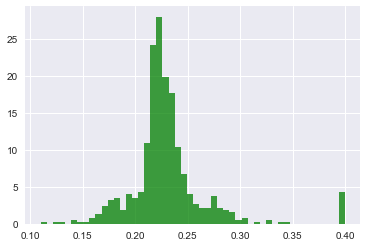

In [938]:
plt.hist(train_dset.data_df['thresh'].map(lambda x: min(x, .4)), 50, normed=1, facecolor='green', alpha=0.75);

In [939]:
scipy.stats.describe(train_dset.data_df['iou'])

DescribeResult(nobs=635, minmax=(0.0, 0.618305024425714), mean=0.042529762398392741, variance=0.011490909947789825, skewness=3.001104387250635, kurtosis=8.864495800890273)

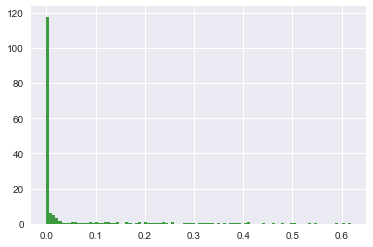

In [941]:
plt.hist(train_dset.data_df['iou'], 100, normed=1, facecolor='green', alpha=0.75);

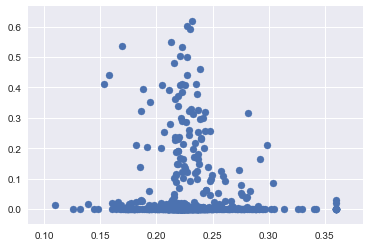

In [942]:
plt.scatter(train_dset.data_df['thresh'].map(lambda x: min(x, .36)),train_dset.data_df['iou'])

# Try Fixed Thresholds

In [ ]:
p=train_dset.data_df['pred'].iloc[0]
def ious_at_thresh(thresh):
    l = []
    for i in tqdm(range(len(train_dset.data_df))):
        img_th = (train_dset.data_df['pred'].iloc[i] > thresh).astype(int)
        l.append(iou_metric(img_th, train_dset.data_df['masks'].iloc[i]))
    return l

threshs=np.linspace(.26, .34, 20)
i = [np.mean(ious_at_thresh(x)) for x in threshs]
plt.plot(threshs,i)


# Plot All Images With IOU 0


In [ ]:
train_dset.data_df['masks'].iloc[i]

(array([  0,   1,   2,   3,   4,   5,   8,  10,  14,  15,  17,  18,  20,
        21,  22,  25,  26,  30,  31,  33,  34,  35,  36,  38,  39,  40,
        42,  43,  46,  47,  48,  50,  54,  56,  57,  59,  61,  65,  67,
        69,  70,  71,  72,  73,  74,  75,  77,  79,  80,  84,  85,  87,
        90,  91,  92,  93,  94,  95,  96,  98, 100, 101, 104, 105, 106,
       107, 109, 110, 111, 116, 117, 118, 119, 120, 121, 122, 123, 125,
       127, 128, 129, 130, 131, 133, 134, 136, 138, 139, 140, 141, 146,
       147, 152, 153, 155, 156, 158, 161, 162, 163, 165, 166, 170, 171,
       172, 176, 180, 181, 182, 183, 185, 186, 187, 188, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 202, 206, 207, 208, 209,
       212, 214, 215, 216, 217, 218, 219, 220, 221, 224, 225, 228, 231,
       233, 234, 235, 236, 239, 240, 243, 244, 245, 246, 247, 248, 249,
       250, 252, 258, 259, 262, 263, 264, 265, 267, 268, 270, 271, 272,
       273, 274, 276, 277, 280, 281, 282, 284, 288, 289, 290, 2

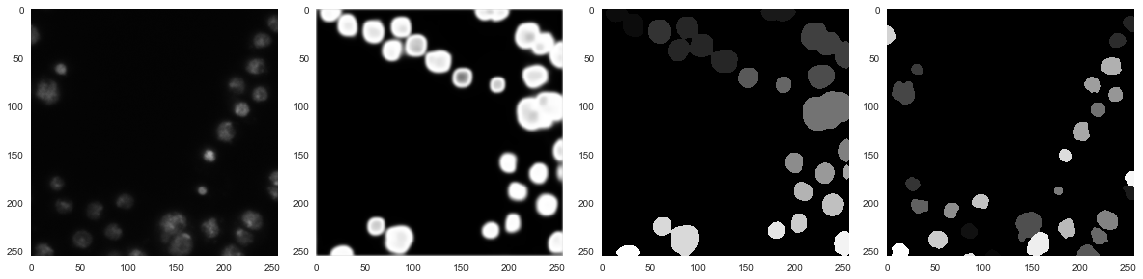

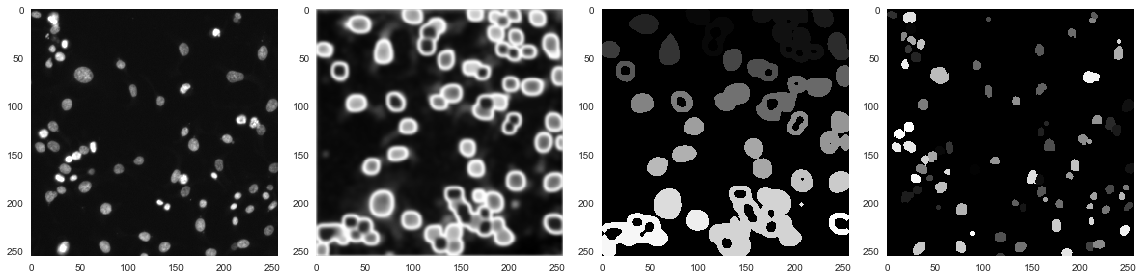

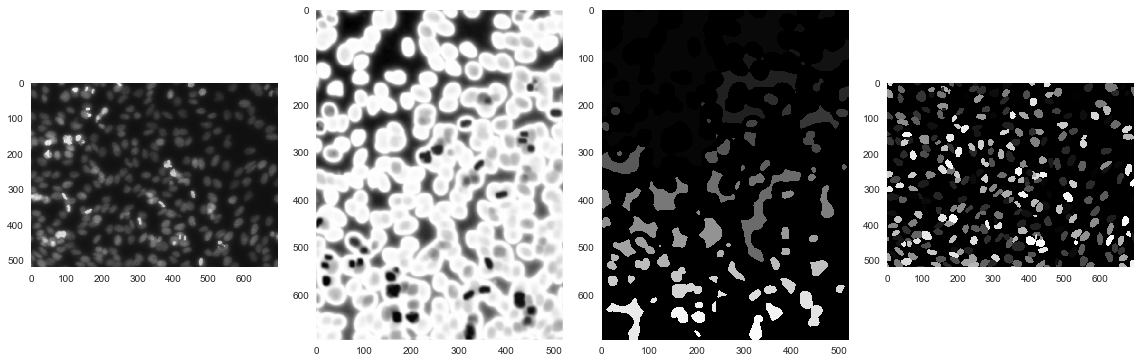

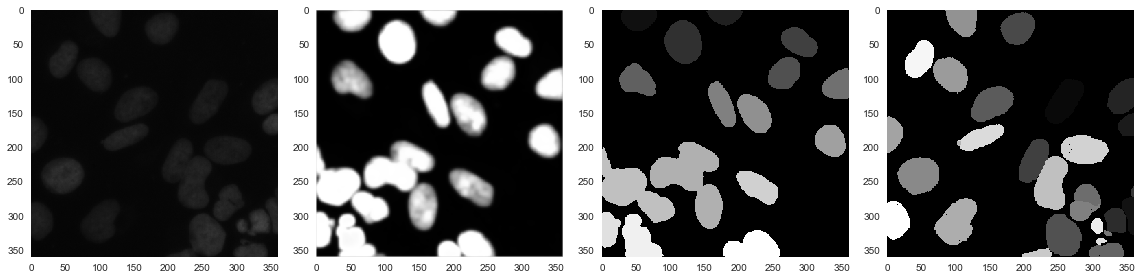

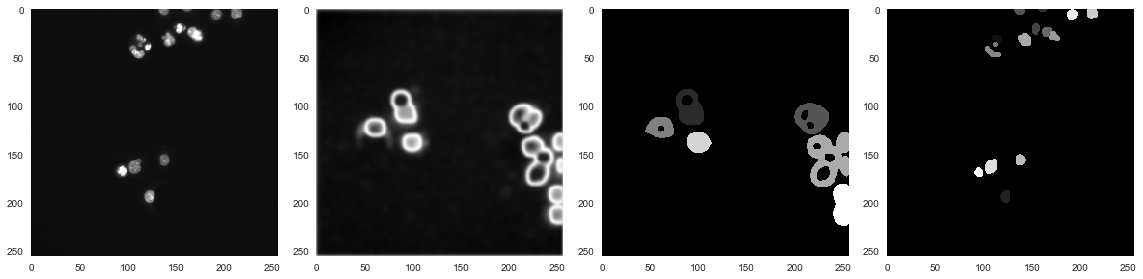

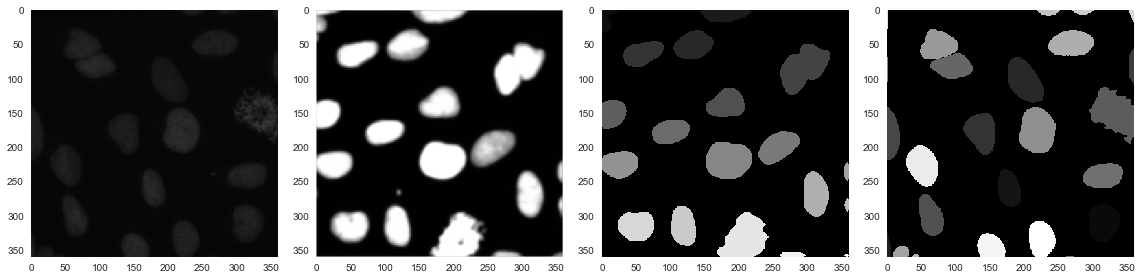

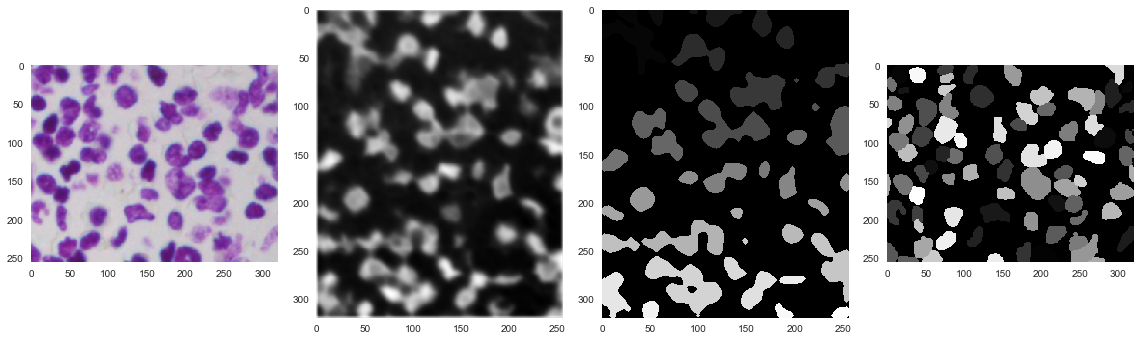

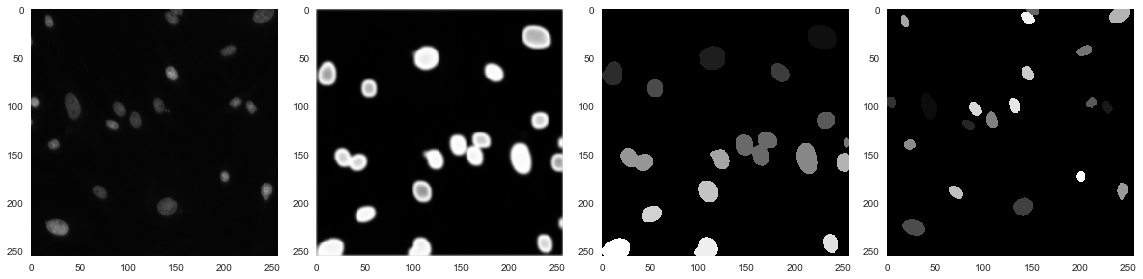

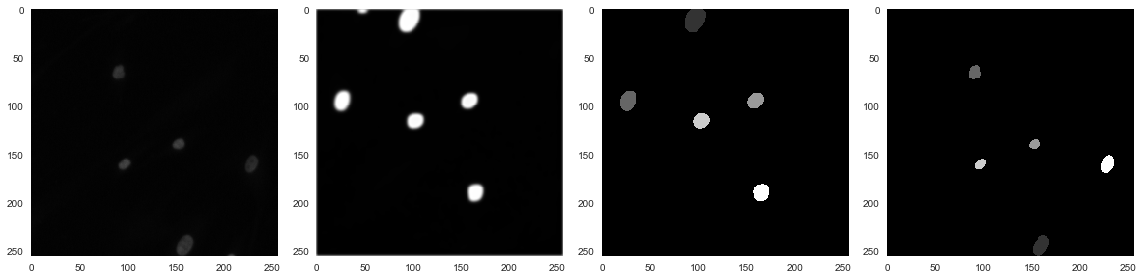

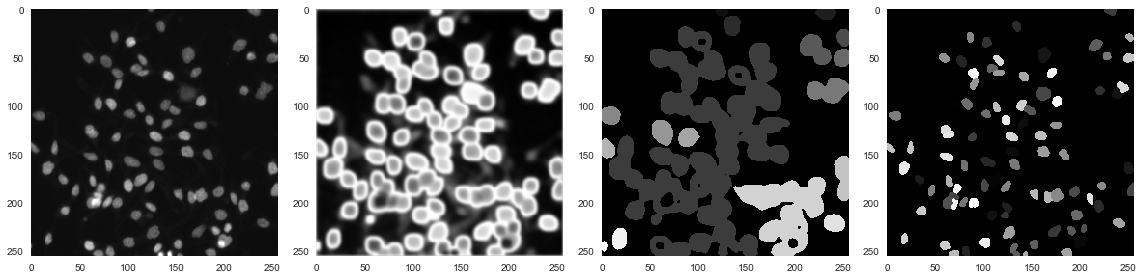

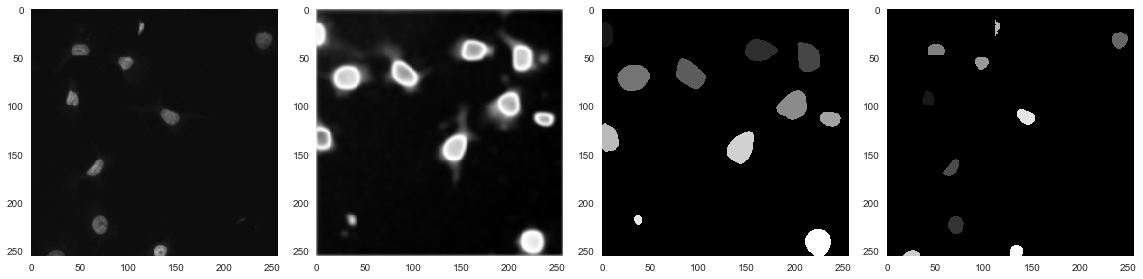

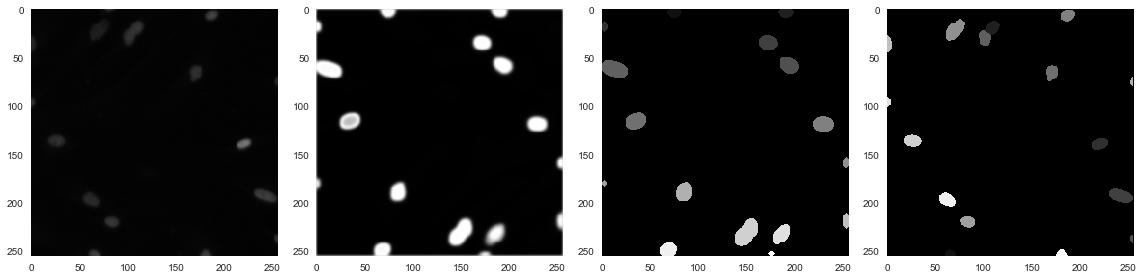

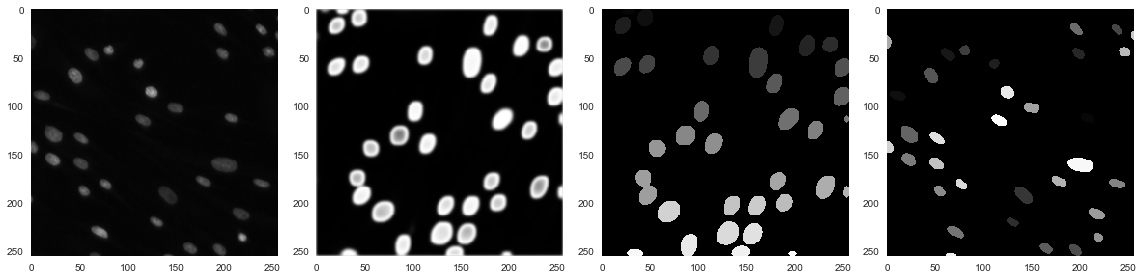

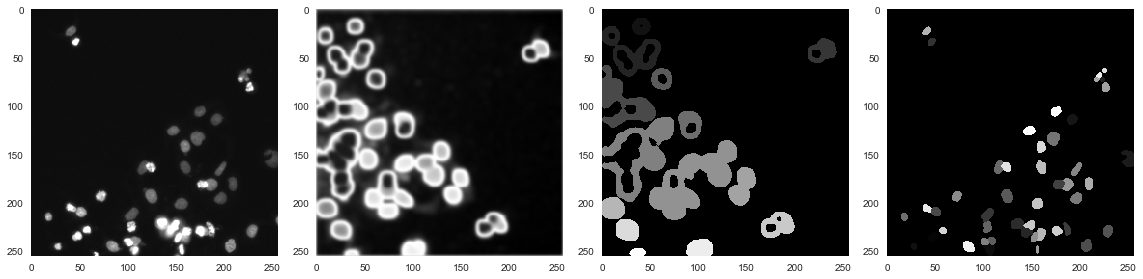

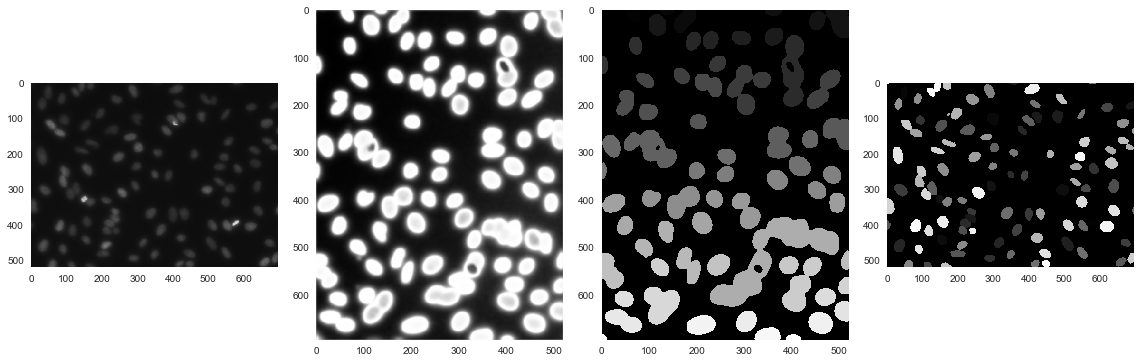

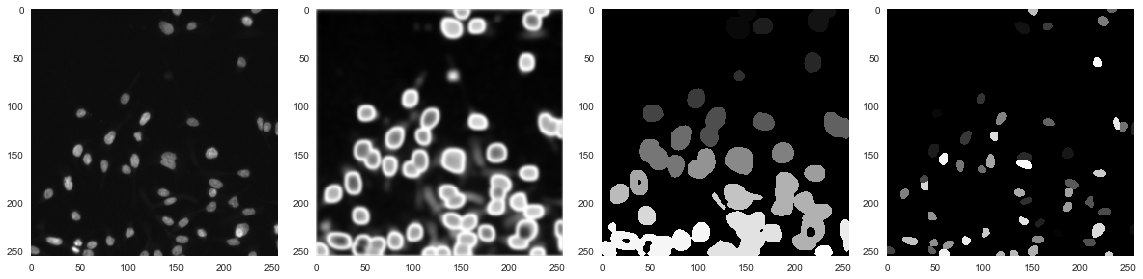

KeyboardInterrupt: 

In [950]:
sel = np.where(np.abs(train_dset.data_df['iou'] - 0.0) <=0.0)
print sel
for i in np.nditer(sel):
    i = np.asscalar(i)
    show_images([train_dset.data_df['images'].iloc[i],
        train_dset.data_df['pred'].iloc[i],
        train_dset.data_df['pred_label'].iloc[i],
        train_dset.data_df['masks'].iloc[i]], 4)


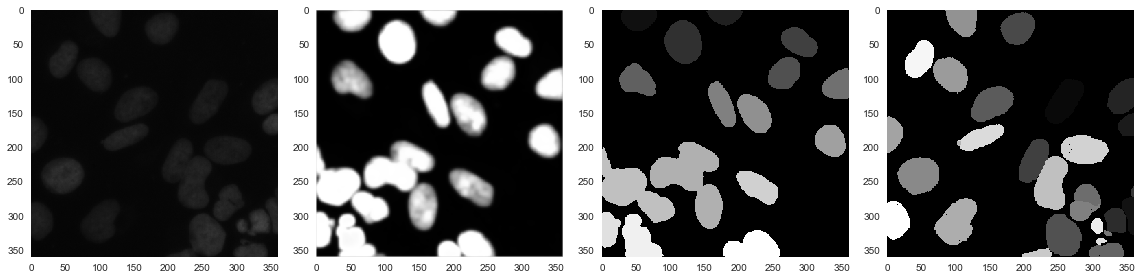

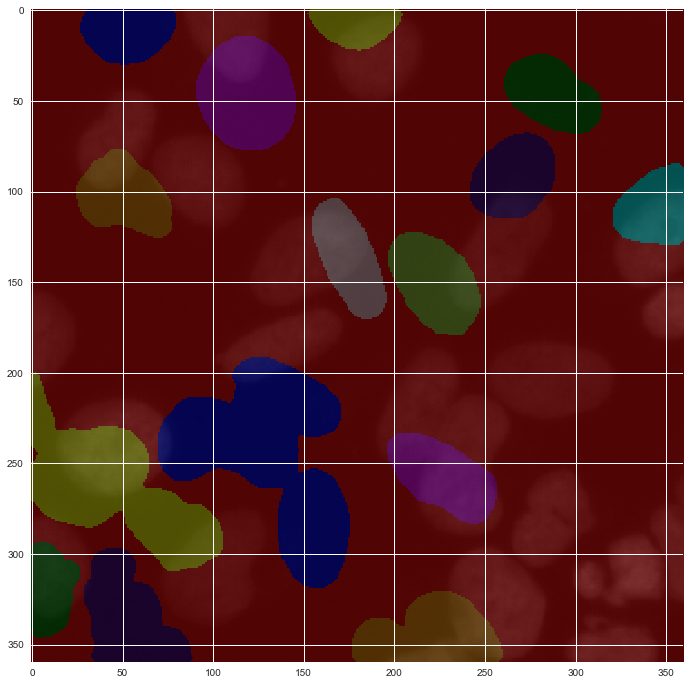

In [952]:
i=3
show_images([train_dset.data_df['images'].iloc[i],
        train_dset.data_df['pred'].iloc[i],
        train_dset.data_df['pred_label'].iloc[i],
        train_dset.data_df['masks'].iloc[i]], 4)
#utils.show_with_contour(train_dset.data_df['images'].iloc[i], 
#                        train_dset.data_df['masks'].iloc[i],
#                       color='green')

ov = label2rgb(train_dset.data_df['pred_label'].iloc[i], train_dset.data_df['images'].iloc[i])
fig, ax = plt.subplots(figsize=(20, 12))
ax.imshow([1, 1, 1] * ov)


In [ ]:
# summary of image formats
dset.data_df.groupby(['format','mode','size']).size()

In [ ]:
modes = dset.data_df['images'].map(lambda x: x.mode)
sizes = dset.data_df['images'].map(lambda x: x.size)
print np.unique(sizes)

# Training

In [ ]:
from torch import optim

print_every = 10
save_every = 10
eval_every = 10
    
epochs = 10

if 1:
    model = CNN()
    it = 0
    best_loss = 1e20
    best_it = 0
    stats = []


criterion = nn.MSELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = loss.DiceLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=1e-4)



#for epoch in range(epochs):
    # adjust_learning_rate(optimizer, epoch)
#    it, best_loss, best_it = train(train_loader, valid_loader, model, criterion, optimizer, stats, epoch, eval_every, print_every, save_every)
#print it, best_loss, best_it



# Single Example Training

loss: 1 0.655611634254 0.177015141247
loss: 2 0.650175571442 0.170552658144
loss: 3 0.643305718899 0.159839099568
loss: 4 0.635904967785 0.143402534012
loss: 5 0.629124939442 0.133930183797
loss: 6 0.623095393181 0.104909384887
loss: 7 0.617777705193 0.0902366090623
loss: 8 0.613307356834 0.0802270590265
loss: 9 0.609877705574 0.0627743392303
loss: 10 0.607512950897 0.0455623465383
loss: 11 0.606121718884 0.0304744180014
loss: 12 0.605555713177 0.016790367135
loss: 13 0.605632781982 0.00478242526894
loss: 14 0.606160402298 0.0078669284728
loss: 15 0.606953322887 0.0174134248206
loss: 16 0.607846677303 0.0256217521789
loss: 17 0.6087064147 0.0324319595389
loss: 18 0.609433054924 0.0377574379942
loss: 19 0.609962165356 0.0416864203977
loss: 20 0.610261797905 0.0442949951792
loss: 21 0.610328197479 0.0456478662455
loss: 22 0.610179722309 0.0458797336558
loss: 23 0.609850406647 0.0451138199302
loss: 24 0.609384059906 0.0434889537105
loss: 25 0.608828306198 0.0411570550993
loss: 26 0.608230

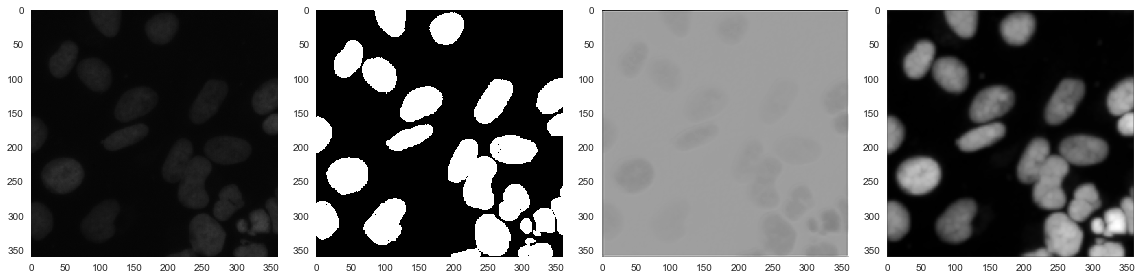

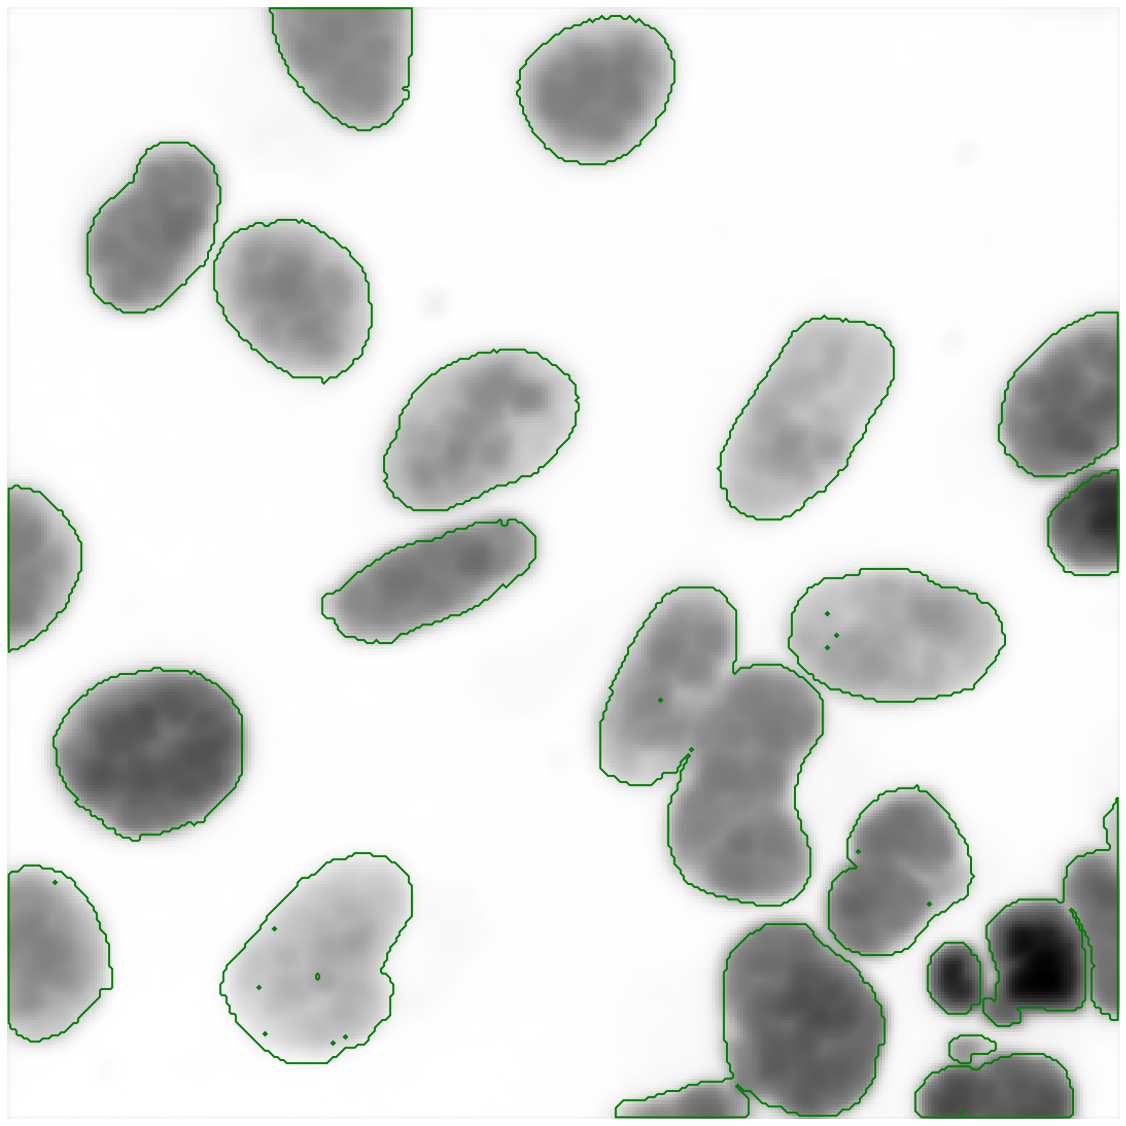

In [1149]:
from adjust_learn_rate import adjust_learning_rate
idx = 3

if 1:
    model = CNN()
    #criterion = nn.MSELoss()
    criterion = nn.BCEWithLogitsLoss(torch.ones((1)))
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    #optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    it=0
    loss=[]
    lrs=[]
    grs=[]
    lr=0.1
    

lr=0.1
adjust_learning_rate(optimizer, lr)

img = train_dset.data_df['images'].iloc[idx]
masks = train_dset.data_df["masks"].iloc[idx]
masks_seg = train_dset.data_df["masks_seg"].iloc[idx]

img_trans, masks_trans, masks_seg_trans = train_transform(img, masks, masks_seg)
img_trans = img_trans.unsqueeze(0)
masks_seg_trans = masks_seg_trans.unsqueeze(0)

epochs=200
pred_before = None
for i in range(epochs):
    it += 1
    model.train(True)
    pred0 = model(Variable(img_trans))
    if i == 0:
        pred_before = pred0
    optimizer.zero_grad()
    loss0 = criterion(pred0, Variable(masks_seg_trans))
    loss0.backward()
    gr = torch.nn.utils.clip_grad_norm(model.parameters(), .25)
    #if it > 150:
    #    lr=0.01
    #    adjust_learning_rate(optimizer, lr)
    #if it > 20:
    #    lr=0.1
    #    adjust_learning_rate(optimizer, lr)
    optimizer.step()
    model.eval()
    pred1 = model(Variable(img_trans))
    loss1 = criterion(pred1, Variable(masks_seg_trans))
    loss.append(loss1.data[0])
    lrs.append(lr)
    grs.append(gr)
    print 'loss:', it, loss1.data[0], gr
    #if loss1.data[0] < 0.4 and it < 100:
    #    lr=0.01
    #    adjust_learning_rate(optimizer, lr)
    #if it >= 100:
    #    lr=0.001
    #    adjust_learning_rate(optimizer, lr)

    
pred_before = pred_before.data.squeeze().numpy()
pred1 = pred1.data.squeeze().numpy()
show_images([img, masks_seg, pred_before, pred1], max_col=4)
utils.show_with_contour(pred1, 
                        masks_seg.squeeze(),
                       color='green')




200


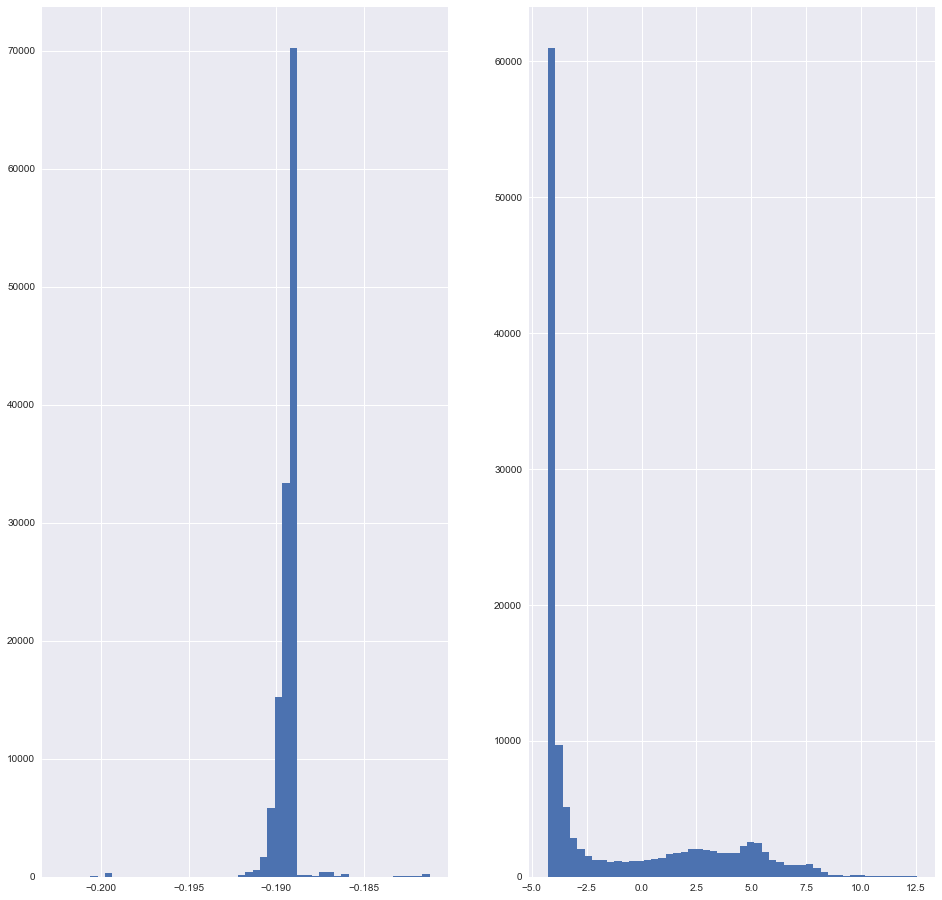

In [1150]:
print it
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].hist(pred_before.flatten(), bins=50);
ax[1].hist(pred1.flatten(), bins=50);


200 0.1


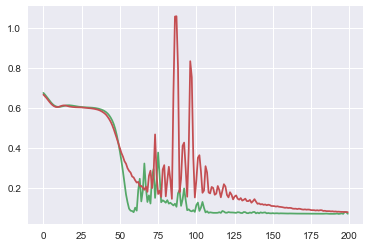

0.133979674858


In [1148]:
print it,lr
#exp_const_001=(loss,lrs)
#exp_const_001_adam=(loss,lrs)
#exp_01_50=(loss,lrs)
#exp_decay_099=(loss,lrs)
#exp_clip_025=(loss,lrs)
#exp_clip_01=(loss,lrs)
#exp_switch_40=(loss,lrs)
#exp_switch_40_red100=(loss,lrs)
#exp_clip_050=(loss,lrs)
#exp_clip_025_warmup20=(loss,lrs)
#exp_clip_025_lower_150=(loss,lrs)
exp_clip_025_wd=(loss,lrs)
fig, ax = plt.subplots( nrows=1, ncols=1 )
#ax.set_ylim((0.05,0.1))
#ax.set_xlim((100,200))
ax.plot(exp_clip_025[0], 'g')
ax.plot(exp_clip_025_wd[0], 'r')
#ax.plot(grs, 'r')
plt.show()    
#print pow(.1,(1.0/50))
print pow(0.99,200)
#scipy.stats.describe(grs)
#np.median(grs)

# Visualize Predictions

In [ ]:
import torchvision.transforms as TT
#monkeypatch(dset, 'transform', train_transform)
#train_dset.transform=train_transform
#valid_dset.transform=train_transform

model.eval()

for img,(_,mask) in iter(train_loader):
    break


pred = model(Variable(img,requires_grad=False))
color_adjust = model.get_color_adjust(Variable(img,requires_grad=False))
coarse = model.get_coarse(Variable(img,requires_grad=False))

show_images([img[0],color_adjust.data[0],mask[0]])
#show_images([img[0],coarse[0].data[0],coarse[1].data[0],coarse[2].data[0],mask[0]])
#show_images([img[0],pred.data[0],mask[0]])

#pred = ToPILImage()(pred.data[0])
#ii = np.array(pred.data[0].squeeze())
#plt.imshow(ii,cmap='gray')
#ii[abs(ii-0.1425)<=0.01]=1
#ii=mask[0]
#print ii.min(), ii.max(), ii.mean(), stats.mode(ii.flatten())
#show_images([img[0],pred.data[0],mask[0]])
#print criterion(pred,Variable(mask))
#print ((pred.data[0]-mask[0])* (pred.data[0]-mask[0])).sum()/pred.data[0].numel()
#print ((mask[0]-mask[0].mean())* (mask[0]-mask[0].mean())).sum()/mask[0].numel()
#print pred.data[0].size()
#plot_img_and_hist(pred.data[0])
#plot_img_and_hist([img,mask])
#mask.mean()
#mask.shape
#show_img([img,mask])
#train_dset.transform
#train_dset.transform=transforms.ToTensor()
#train_dset.transform
#TT.ToPILImage()(img)
#show_images(pred.data[0])
#plt.imshow(ToPILImage()(pred.data[0]))
#plt.imshow(pred.data[0].numpy().squeeze())
#plt.imshow(img_as_float(pred.data[0].numpy().squeeze()))

#print isinstance(pred.data[0], torch.Tensor)


#print baseline(train_loader, valid_loader, criterion, 1000)
#def is_inverted(img,invert_thresh_pd=10.0):
#    img_grey = img_as_ubyte(rgb2grey(img))
#    img_th = cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]
#    return np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))

#print is_inverted(train_dset.data_df['images'].iloc[0])
#x = train_dset.data_df['images'].map(is_inverted)
#print np.where(train_dset.data_df['inv'])
#ii = train_dset.data_df['images'].iloc[71]
#plt.imshow(rgb2grey(ii),cmap='binary')
#plt.imshow(ii[:10,:10]-5)
#ii[:10,:10]

#show_images(rgb2grey(ii))

#plot_img_and_hist(rgb2grey(ii))
#train_dset.data_df['id'].iloc[71]
#print ii.dtype, ii.mean(), ii.max(), ii.min(), stats.mode(ii.flatten())
#plt.imshow(ii)

In [ ]:
# pixel correlation plot
x=pred.data[0].numpy().flatten()
y=mask[0].numpy().flatten()
plt.scatter(y,x)
plt.show()

In [ ]:
epoch,stats=load_model(model, optimizer)
print epoch, stats

# Calculate IOU

In [ ]:
#loss=reload(loss)
import scipy
from tqdm import tqdm
#post_process=reload(post_process)
import loss
import post_process
from post_process import parametric_pipeline
from loss import iou_metric, diagnose_errors, show_compare_gt
#model.eval()
#pred = [(model(Variable(img,requires_grad=False)).data.numpy().squeeze(), mask.numpy().squeeze()) for img, (mask,mask_seg) in tqdm(iter(train_loader))]
#pred = [(ToPILImage()(img.squeeze()),mask.numpy().squeeze()) for img, (mask,mask_seg) in iter(valid_loader)]
#img_th = [(parametric_pipeline(rgb2grey(np.asarray(img)),circle_size=4), mask) for img, mask in pred]
#ious = [iou_metric(i,m) for (i,m) in img_th]
print np.mean(ious),np.median(ious)
#diagnose_errors(img_th[0][0],img_th[0][1])
#show_compare_gt(pred[2][0],pred[2][1],circle_size=10)
#print pred[0][0].dtype
#pred[0]

In [ ]:
dice 0.239599661927 0.221256282842
jaccard 0.23728979728 0.189091591261
bce 0.279290088953 0.217723006553
mse 0.304971608193 0.309523258999
new arch
mse 0.158894834172 0.114834653566
bce mean = 0.17207, med = 0.12120
dice mean = 0.24912, med = 0.19799
img-weighted bce 0.22999, med = 0.18525

In [ ]:
###### dset.data_df['masks_unlabeled']=dset.data_df['masks_unlabled']

#for i,(img,mask) in enumerate(valid_loader):
#    break

#print mask[1].dtype
#dset.data_df['masks'].iloc[0].max()
#ii=np.array(((1,2,3),(4,5,5)),dtype=np.uint8)
#print torch.from_numpy(ii)
img=dset.data_df['images'].iloc[0]
m1=dset.data_df['masks'].iloc[0]
m2=dset.data_df['masks_seg'].iloc[0]
ii,mm1,mm2=train_transform(img,m1,m2)
print mm1.shape,mm2.shape

In [ ]:
ii=np.zeros((2,3,1))
print np.flip(ii,2).shape

In [ ]:
np.rot90

In [ ]:
print stats

In [ ]:
import matplotlib.pyplot as plt
import operator
from operator import itemgetter

xs = map(itemgetter(0), stats)
ys = map(itemgetter(1), stats)
zs = map(itemgetter(2), stats)


fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(xs,ys,'g')
ax.plot(xs,zs,'r')
plt.show()
#fig.savefig('path/to/save/image/to.png')   # save the figure to file
#plt.close(fig)    # close the figure
#print xs

In [ ]:
x=pd.DataFrame({'x':[1,2,3,4],'y':[1,2,3,4]})
x['x'].map(lambda x: x + 1)
#x['x'].map(lambda x: x + 1)
[x+1 for x in tqdm(x['x'])]

In [ ]:
from utils import load_object
img=load_object('/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/FOOTPRINT.pkl')

In [1156]:
1 % 2

0